### Import packages

In [132]:
#database query
import sqlite3
import pandas as pd

#location
import zipcodes

#text cleaning
from bs4 import BeautifulSoup as bs
import re
import fasttext

#api
import requests

#misc
import numpy as np

### Query database

In [133]:
conn = sqlite3.connect("../data/db/gfm.db")

In [134]:
feed = pd.read_sql_query("SELECT * FROM feed_tb", conn)

In [135]:
donation = pd.read_sql_query("SELECT * FROM donation_tb", conn)

In [136]:
update = pd.read_sql_query("SELECT * FROM update_tb", conn)

### Select columns of interest for analysis

In [137]:
cols_to_keep = [
 'url',
 'donation_count',
 'donor_reached_max',
 'currencycode', 
 'current_amount',
 'goal_amount',
 'fund_name',
 'fund_description',
 'created_at',
 'social_share_last_update',
 'city',
 'country',
 'postal_code',
 'is_team'
]

In [138]:
feed = feed[cols_to_keep]

### Remove duplicated urls

In [139]:
original_n = feed.shape[0]

In [140]:
feed = feed.drop_duplicates('url')

In [141]:
duplicated_n_removed = original_n - feed.shape[0]

### Extract date variables

In [142]:
feed.loc[:,'year'] = [x.split("-")[0] for x in feed['created_at']]

In [143]:
feed.loc[:,'month'] = [x.split("-")[1] for x in feed['created_at']]

# Clean location data

### Clean zip codes

#### Inpsect length of zip codes

See ZIP code prefixes here: https://en.wikipedia.org/wiki/List_of_ZIP_Code_prefixes

In [144]:
feed['postal_code'] = feed['postal_code'].astype(str)

In [145]:
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5     85547
4      6996
3       224
0       101
1        24
10       11
7         7
6         6
35        5
9         3
17        3
25        3
24        3
21        3
15        3
2         3
12        3
18        2
8         2
20        2
13        2
11        2
19        2
16        1
22        1
26        1
27        1
33        1
Name: zip_len, dtype: int64

In [146]:
feed[feed['zip_len'] == 3]['city'].sample(10)

50180        Toa Alta, PR
113           Arecibo, PR
98338         Bayamon, PR
13581                    
8061     Quebradillas, PR
93484        Mayaguez, PR
36217           YAUCO, PR
7078          St John, VI
67895                    
65344          Aguada, PR
Name: city, dtype: object

In [147]:
feed[feed['zip_len'] == 4]['city'].sample(10)

58713          Sturbridge, MA
2877              Norfolk, CT
52653              Oxford, CT
91920          Pittsfield, MA
48048    East Millinocket, ME
42024             Bedford, NH
35343          Bloomfield, NJ
58436         Northampton, MA
21360          Farmington, ME
29699             Milford, NH
Name: city, dtype: object

#### Zfill zip code to 5

In [148]:
feed['postal_code'] = feed['postal_code'].str.zfill(5)

In [149]:
#recalculate zip length, append to dataframe
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5     92895
10       11
7         7
6         6
35        5
9         3
21        3
25        3
24        3
17        3
15        3
12        3
8         2
18        2
19        2
11        2
13        2
20        2
16        1
22        1
26        1
27        1
33        1
Name: zip_len, dtype: int64

#### Inspect and extract additional zip code data

In [150]:
#export data to inspect zip codes longer than 5 characters, extract zip codes where appropriate
feed.loc[feed['zip_len'] > 5,['url','fund_name','city','postal_code']].to_csv('../data/census/extract_zip.csv', index=False)

In [151]:
#import and clean labeled data
extract_zip_labeled = pd.read_csv('../data/census/extract_zip_labeled.csv')
extract_zip_labeled = extract_zip_labeled[extract_zip_labeled['zip_extract'].notna()]
extract_zip_labeled['zip_extract'] = extract_zip_labeled['zip_extract'].astype(int).astype(str).str.zfill(5)

In [152]:
#add extracted zip codes to feed data
feed = feed.merge(extract_zip_labeled[['url','zip_extract']], on='url', how='left')
feed.loc[feed['zip_extract'].notna(),'postal_code'] = feed.loc[feed['zip_extract'].notna(),'zip_extract']

In [153]:
feed.loc[:,'zip_len'] = [len(x) for x in feed['postal_code']]
feed['zip_len'].value_counts()

5     92937
7         7
6         6
35        5
15        2
8         1
9         1
11        1
12        1
33        1
Name: zip_len, dtype: int64

#### Remove zip codes with length > 5

In [154]:
starting_n = feed.shape[0]
feed = feed[feed['zip_len'] < 6]
zip_code_greater_5_n_removed = starting_n - feed.shape[0]

### Add county data

In [155]:
#HUD zip to county
hud = pd.read_excel('../data/census/ZIP_COUNTY_122020.xlsx')[['ZIP','COUNTY','TOT_RATIO']]

#clean hud data
#rename columns
hud.columns = ['zip','state_county_fips','tot_ratio']

#convert data to strings, fill zip code with leading zeros
hud['zip'] = hud['zip'].astype(str).str.zfill(5)
hud['state_county_fips'] = hud['state_county_fips'].astype(str).str.zfill(5)

In [156]:
hud.shape

(54194, 3)

In [157]:
hud['zip'].nunique()

39455

In [158]:
#some zip codes map to multiple counties
#match zip code to the county that contains the highest proportion of that zip's total addresses
hud = hud.sort_values(by='tot_ratio', ascending=False)
hud = hud.drop_duplicates(subset='zip', keep="first")

In [159]:
hud.shape

(39455, 3)

In [160]:
#merge hud data with feed
feed = feed.merge(hud, left_on='postal_code', right_on='zip', how='left')

In [161]:
feed['zip'].isna().sum()

396

In [162]:
feed[feed['zip'].isna()]['city'].head(20)

19       Babson Park, MA
1131                    
1369                    
1431                 FPO
1655                    
1787                    
1858                    
1862           Miami, FL
2182             APO, US
2361                    
2461                    
2784       United States
3547      Cincinnati, OH
3752       Arlington, VA
3790                    
3885                    
3965                    
4187       Henderson, TX
4441                    
4482    Far Rockaway, NY
Name: city, dtype: object

In [163]:
feed[feed['zip'].isna()]['year'].value_counts(normalize=True)

2016    0.320707
2020    0.209596
2019    0.143939
2015    0.108586
2018    0.095960
2017    0.068182
2014    0.042929
2013    0.007576
2011    0.002525
Name: year, dtype: float64

There is no clear systematic reason for unmapped zip codes. We will exclude these.

#### Remove unmapped zip codes

In [164]:
starting_n = feed.shape[0]
feed = feed[feed['zip'].notna()]
unmapped_zip_n_removed = starting_n - feed.shape[0]

In [165]:
feed['state_county_fips'].isna().sum()

0

### Get census data
- Census API: American Community Survey 2019 5 year estimates, Data Profile API (https://www.census.gov/data/developers/data-sets/acs-5year.html)
- Data annotation reference: https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-estimate-and-annotation-values.html

In [166]:
#import list of variables
variable_df = pd.read_csv('../data/census/acs_variables.csv')
variables = variable_df['variable_call'].to_list()
vars_to_get = ','.join(variables)

In [167]:
#census api key
import sys
sys.path.append('../src/')
import tokens

census_key = tokens.CENSUS_KEY

In [168]:
#census api call
base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
                    vars_to_get+
                    "&for=county:*&in=state:*&key=")

# zip code tabulation area
# base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
#                     vars_to_get+
#                     "&for=zip%20code%20tabulation%20area:*&in=state:*&key=")


full_request = base_request + census_key

r = requests.get(full_request)
r_json = r.json()

census = pd.DataFrame(data=r_json[1:][:], columns=r_json[0][:])
new_names = dict(zip(variable_df['variable_call'].to_list(), variable_df['variable_label'].to_list()))
census.rename(columns=new_names, inplace=True)

In [169]:
census['state_county_fips'] = census['state'] + census['county']

In [170]:
#inspect for extreme values
census.drop('NAME', axis=1).astype(float).describe().T

,count,mean,std,min,25%,50%,75%,max
total_population,3220.0,101868.398137,3.273446e+05,66.0,11193.750,25946.00,66723.75,10081570.0
percent_female,3220.0,49.963354,2.348955e+00,27.3,49.400,50.40,51.20,57.2
unemployment_rate,3220.0,5.572764,3.361886e+00,0.0,3.700,5.00,6.60,34.1
median_income,3220.0,52648.046584,1.498983e+04,12441.0,43524.000,51485.50,59519.25,142299.0
percent_poverty,3220.0,11.602609,7.504720e+00,0.0,7.100,10.00,13.80,59.9
no_health_insurance,3220.0,9.549627,5.086483e+00,0.0,5.700,8.60,12.00,46.3
public_health_insurance,3220.0,40.109565,9.899794e+00,13.5,33.300,39.70,45.80,80.3
private_health_insurance,3220.0,64.686149,1.155693e+01,13.3,58.100,65.90,72.90,92.7
home_owners,3220.0,71.556708,8.306971e+00,0.0,67.500,72.80,77.10,93.1
percent_1_1.5_per_room,3220.0,1.745776,1.547206e+00,0.0,0.900,1.40,2.10,21.5


In [171]:
#inspect for '-' and '*' annotations
for col in census.columns:
    if census[col].str.contains('\-').any():
        print(col,": ",'-')
    if census[col].str.contains('\*').any():
        print(col,": ",'*')

NAME :  -
home_median_value :  -


In [172]:
census[census['home_median_value'].astype(float) < 0]

,NAME,total_population,percent_female,unemployment_rate,median_income,percent_poverty,no_health_insurance,public_health_insurance,private_health_insurance,home_owners,...,percent_18_and_over,median_age,percent_black,percent_hispanic_latino,percent_public_assist,percent_mgmt_art_sci,percent_vacant_units,state,county,state_county_fips
163,"Kalawao County, Hawaii",66,54.5,0.0,69375,22.2,0.0,19.7,83.6,0.0,...,98.5,57.4,3.0,3.0,5.1,23.1,58.5,15,005,15005
1530,"Loving County, Texas",98,44.9,0.0,83750,0.0,12.2,25.5,84.7,63.3,...,74.5,55.2,0.0,12.2,0.0,30.3,54.5,48,301,48301


Two counties do not have available data for home_median_value. 

However, this variable is not used in PCA, so we can keep those counties in the data.

#### Prepare data for PCA

In [173]:
#copied from "Get census data.ipynb"
census['percent_crowding'] = census['percent_1_1.5_per_room'].astype(float) + census['more_1.5_per_room'].astype(float)
census['percent_single_parent'] = census['single_dad'].astype(float) + census['single_mom'].astype(float)
census['state_int'] = census['state'].astype(int)
census = census[census['state_int']<=56]

In [174]:
#copied from "Get census data.ipynb"
income_ineq_req = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B19083_001E&for=county:*&in=state:*&key="
income_ineq_req = income_ineq_req + census_key
response = requests.get(income_ineq_req)
results = response.json()

In [175]:
#copied from "Get census data.ipynb"

new = pd.DataFrame(data=results[1:][:], columns=results[0][:])

all_vars = pd.merge(census, new, how='left', on='NAME')
all_vars.drop(columns=['state_x', 'county_x'], inplace=True)
all_vars.rename(columns={'B19083_001E':'gini_income_inequality', 'state_y':'state',
                         'county_y':'county'}, inplace=True)
all_vars['percent_less_35k'] = (all_vars['percent_less_10k'].astype(float) + all_vars['percent_10k_15k'].astype(float) + 
                                all_vars['percent_15k_25k'].astype(float) + all_vars['percent_25k_35k'].astype(float))

In [176]:
all_vars.to_csv('../data/census/all_vars_by_county.csv')

#### -------- V -----------
#### ---> Run PCA in R <---
#### -------- ^ -----------

#### Import PCA data and calculate neighborhood deprivation index

In [177]:
pca = pd.read_csv('../data/census/census_w_factor_weights.csv')

In [178]:
colnames = pca.columns.to_list()
cols_to_sum = [i for i in colnames if 'weighted' in i]

In [179]:
pca['sum'] = 0
for c in cols_to_sum:
    pca['sum'] += pca[c]

In [180]:
cols_to_sum.append('state_county_fips')
cols_to_sum.append('sum')
pca = pca[cols_to_sum]

In [181]:
census = pd.read_csv('../data/census/all_vars_by_county.csv')

In [182]:
from sklearn import preprocessing
pca['standardized_ndi'] = preprocessing.scale(pca['sum'])
pca = pd.merge(pca, census, how='left', on='state_county_fips')

QUANTS = (np.quantile(pca['standardized_ndi'].values, [.25, .5, .75]))

def _get_quantile(x):
    if x <= QUANTS[0]:
        return 1
    if x > QUANTS[0] and x <= QUANTS[1]:
        return 2
    if x > QUANTS[1] and x <= QUANTS[2]:
        return 3
    if x > QUANTS[2]:
        return 4
    
cols_to_drop = [c for c in pca.columns.to_list() if 'weighted' in c]

pca['ndi_quantile'] = pca['standardized_ndi'].apply(_get_quantile)

pca.drop(columns = cols_to_drop, inplace=True)

<AxesSubplot:>

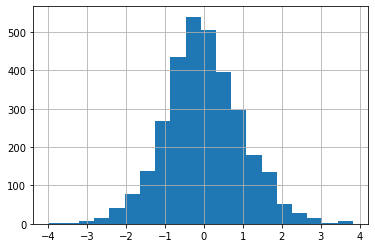

In [183]:
pca['standardized_ndi'].hist(bins=20)

<AxesSubplot:xlabel='ndi_quantile', ylabel='median_income'>

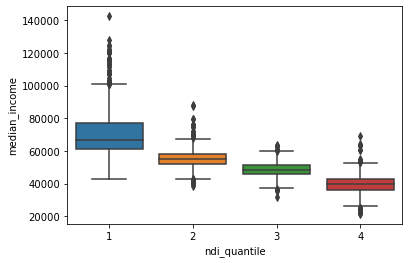

In [184]:
#inspect example data
import seaborn as sns
sns.boxplot(x='ndi_quantile',y='median_income',data=pca)

##### Merge data

In [185]:
#rename and reformat variables before merging
pca = pca[['state_county_fips','NAME','ndi_quantile','standardized_ndi']]
pca.rename(columns={'NAME':'county_name'}, inplace=True)
pca['state_county_fips'] = pca['state_county_fips'].astype(str).str.zfill(5)

In [186]:
#rename feed columns before merging
feed.rename(columns={'state':'state_abb'}, inplace=True)

In [187]:
#merge ndi data with feed data
feed = feed.merge(pca, on='state_county_fips', how='left')

In [189]:
#merge census data with feed data
census = census.drop(['Unnamed: 0','NAME','state_int','state','county'], axis=1)
census['state_county_fips'] = census['state_county_fips'].astype(str)
feed = feed.merge(census, on='state_county_fips', how='left')

### Add state data

In [191]:
#state data
import utils
state_list = utils.state_list
state_abb = utils.us_state_abbrev
state_abb = {v:k for k,v in state_abb.items()}
state_fips = utils.state_fips
state_fips = {v:k for k,v in state_fips.items()}

#### Extract state FIPS

In [192]:
feed['state_fips'] = [x[:2] for x in feed['state_county_fips']]

#### Add state abbreviation and name from FIPS

In [193]:
feed['state_abb'] = feed['state_fips'].map(state_fips)

In [194]:
feed['state_name'] = feed['state_abb'].map(state_abb)

#### Add state population

In [195]:
#get population by state from census api
vars_to_get = 'DP05_0001E' #population

base_request = ("https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,"+
                    vars_to_get+
                    "&for=state:*&key=")

full_request = base_request + census_key

r = requests.get(full_request)
r_json = r.json()
state_pop = pd.DataFrame(data=r_json[1:][:], columns=r_json[0][:])
state_pop.columns = ['state_name','state_population','state_fips']

state_pop.to_csv('../data/census/state_pop.csv', index=False)

In [196]:
feed = feed.merge(state_pop[['state_name','state_population']], on='state_name', how='left')

#### Add census regions

In [197]:
#import census regions
census_regions = pd.read_csv('../data/census/census_regions.csv')
census_regions.columns = ['state_name','state_abb','census_region','census_division']
del census_regions['state_abb'] #redundant

In [198]:
#merge census regions
feed = feed.merge(census_regions, on='state_name', how='left')

### Remove locations that are not US 50 states + DC

In [199]:
starting_n = feed.shape[0]
feed = feed[feed['state_abb'].isin(state_list)]
locations_outside_US_n_removed = starting_n - feed.shape[0]

### Check NA values

In [202]:
feed.isnull().sum()[:50]

url                             0
donation_count                  0
donor_reached_max               0
currencycode                    0
current_amount                  0
goal_amount                     0
fund_name                       1
fund_description                0
created_at                      0
social_share_last_update        0
city                            0
country                         0
postal_code                     0
is_team                         0
year                            0
month                           0
zip_len                         0
zip_extract                 92268
zip                             0
state_county_fips               0
tot_ratio                       0
county_name                     6
ndi_quantile                    6
standardized_ndi                6
total_population            17829
percent_female              17829
unemployment_rate           17829
median_income               17829
percent_poverty             17829
no_health_insu

In [203]:
feed.isnull().sum()[50:]

percent_10_to_14           17829
percent_15_to_19           17829
percent_20_to_24           17829
percent_25_to_34           17829
percent_35_to_44           17829
percent_45_to_54           17829
percent_55_to_59           17829
percent_60_to_64           17829
percent_65_to_74           17829
percent_75_to_84           17829
percent_85_over            17829
percent_65_and_over        17829
percent_18_and_over        17829
median_age                 17829
percent_black              17829
percent_hispanic_latino    17829
percent_public_assist      17829
percent_mgmt_art_sci       17829
percent_vacant_units       17829
percent_crowding           17829
percent_single_parent      17829
gini_income_inequality     17829
percent_less_35k           17829
state_fips                     0
state_abb                      0
state_name                     0
state_population               0
census_region                  0
census_division                0
dtype: int64

In [204]:
#delete zip extract
del feed['zip_extract']

In [205]:
#fill NA fund name with blank string
feed['fund_name'] = feed['fund_name'].fillna(' ')

In [206]:
#inspect county name
feed[feed['county_name'].isna()]['state_name'].value_counts()

South Dakota    4
Alaska          2
Name: state_name, dtype: int64

In [207]:
#remove missing county name
starting_n = feed.shape[0]
feed = feed[~feed['county_name'].isna()]
missing_county_n_removed = starting_n - feed.shape[0]

In [209]:
#recheck NA
feed.isna().sum()[:50]

url                             0
donation_count                  0
donor_reached_max               0
currencycode                    0
current_amount                  0
goal_amount                     0
fund_name                       0
fund_description                0
created_at                      0
social_share_last_update        0
city                            0
country                         0
postal_code                     0
is_team                         0
year                            0
month                           0
zip_len                         0
zip                             0
state_county_fips               0
tot_ratio                       0
county_name                     0
ndi_quantile                    0
standardized_ndi                0
total_population            17823
percent_female              17823
unemployment_rate           17823
median_income               17823
percent_poverty             17823
no_health_insurance         17823
public_health_

In [210]:
feed.isna().sum()[50:]

percent_15_to_19           17823
percent_20_to_24           17823
percent_25_to_34           17823
percent_35_to_44           17823
percent_45_to_54           17823
percent_55_to_59           17823
percent_60_to_64           17823
percent_65_to_74           17823
percent_75_to_84           17823
percent_85_over            17823
percent_65_and_over        17823
percent_18_and_over        17823
median_age                 17823
percent_black              17823
percent_hispanic_latino    17823
percent_public_assist      17823
percent_mgmt_art_sci       17823
percent_vacant_units       17823
percent_crowding           17823
percent_single_parent      17823
gini_income_inequality     17823
percent_less_35k           17823
state_fips                     0
state_abb                      0
state_name                     0
state_population               0
census_region                  0
census_division                0
dtype: int64

### Identify campaigns with "research" in title

In [211]:
feed.loc[:,'research_in_title'] = (feed['fund_name'].str.lower().str.contains('research'))
feed['research_in_title'] = feed['research_in_title'].astype(int)

### Clean text data

In [212]:
def CleanText(t):
    '''
    input: text string t
    output: cleaned text string r
    '''
    
    #regular expression to remove url
    url_reg = r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?'
    
    #regular expression to remove emojis
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)
    
    #strip html elements, replace line breaks and alternative characters
    r = bs(t).get_text()
    r = r.replace("\n","")
    r = r.replace(u'\xa0', u' ')
    
    #strip urls
    r = re.sub(url_reg,'',r)
    
    #strip emojis
    r = re.sub(emoji_pattern,'',r)
    
    #strip leading and trailing whitespace
    r = r.strip()
    
    #return response
    return r

In [213]:
#apply cleaning function, takes about a minute
feed.loc[:,'fund_description_clean'] = [CleanText(x) for x in feed['fund_description']]

/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "/" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [214]:
#inspect a few

print(feed['fund_description'][111][:500])
print("\n")
print(feed['fund_description_clean'][111][:500])
print("\n")
print(feed['fund_description'][60006][:500])
print("\n")
print(feed['fund_description_clean'][60006][:500])

<br /><br />UPDATE: Sweet little Jace passed away on June 18th, 2015. Any donations to this fund will be used to cover funeral costs. Thank you to everyone and please keep the Chynoweth family in your prayers. <br /><br />ORIGINAL POST: Klay and Shayne's sweet little Jace has been diagnosed with a malignant brain tumor and we would like to help the family with financial, as well as other expenses, and hopefully give them the opportunity to stay home and enjoy what time Jace has left.<br /><br />


UPDATE: Sweet little Jace passed away on June 18th, 2015. Any donations to this fund will be used to cover funeral costs. Thank you to everyone and please keep the Chynoweth family in your prayers. ORIGINAL POST: Klay and Shayne's sweet little Jace has been diagnosed with a malignant brain tumor and we would like to help the family with financial, as well as other expenses, and hopefully give them the opportunity to stay home and enjoy what time Jace has left.Any donations on their behalf are

In [215]:
#remove raw text and replace with cleaned text
del feed['fund_description']
feed = feed.rename(columns={'fund_description_clean':'fund_description'})

### Identify non-English campaigns

In [216]:
def GetLanguage(df):
    path_to_pretrained_model = '../data/fasttext_models/lid.176.bin'
    fmodel = fasttext.load_model(path_to_pretrained_model)
    r = fmodel.predict(feed['fund_description'].to_list())
    labels = r[0]
    labels = [i[0].split('__')[2] for i in labels]
    scores = r[1]
    scores = [i[0] for i in scores]
    return labels, scores

In [217]:
#apply function, takes about a minute
feed.loc[:,'language'], feed.loc[:,'language_score'] = GetLanguage(feed)

### Add donations statistics

In [218]:
#inspect donation data
donation.head()

,don_id,online_id,url,don_amt,don_offline,don_anon,don_name,don_date,don_profile,don_verified
0,1,75288239,https://www.gofundme.com/f/Amarilindo,10.0,0,0,Patrice Whitely,2016-03-13T16:09:18-05:00,,1
1,2,72701479,https://www.gofundme.com/f/Amarilindo,20.0,0,0,cheryl redman,2016-03-03T07:19:35-06:00,,1
2,3,72113923,https://www.gofundme.com/f/Amarilindo,25.0,0,0,Stephanie C,2016-03-01T08:44:25-06:00,,1
3,4,71698975,https://www.gofundme.com/f/Amarilindo,30.0,0,0,Tracy H,2016-02-28T12:22:35-06:00,,1
4,5,71101151,https://www.gofundme.com/f/Amarilindo,50.0,0,0,Yosh Takashima,2016-02-25T18:45:31-06:00,,1


In [219]:
don = donation[['url','don_amt']].groupby('url').agg(['min', 'max','mean','median'])

In [220]:
don = don.reset_index()

In [221]:
don.columns = don.columns.droplevel(0)

In [222]:
don.columns = ['url','donation_min','donation_max','donation_mean','donation_median']

In [223]:
master = feed.merge(don, how='left', on='url')

In [224]:
master.shape

(92301, 85)

### Add update statistics

In [225]:
#inspect updates data
update.head()

,update_id,id,author,author_type,user_profile_url,media_type,status,update_text,created_at,url,photo_url,update_data_error
0,1,7264789,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,It&#039;s been a very scary month for me. I ha...,2016-03-01T06:14:33-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
1,2,7071131,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,This is Amari&#039;s vitals today!,2016-02-19T09:04:17-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
2,3,7071069,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,Amari has come a long way since we first came ...,2016-02-19T09:00:39-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
3,4,7029203,Natalie Lindo,ORGANIZER,https://graph.facebook.com/v7.0/16708535265169...,1,1,Last night Amari&#039;s sister Brooke-Lynn who...,2016-02-17T05:52:07-06:00,https://www.gofundme.com/f/Amarilindo,https://7468669c0013a7dae459-4d0fcf8d315d40f30...,None
4,5,6705617,Janet Stern Capron,ORGANIZER,https://graph.facebook.com/v7.0/10208115198308...,1,1,"Dear friends of Antony,\r\nJust a brief update...",2016-01-28T23:52:24-06:00,https://www.gofundme.com/f/m6gg66vd,None,None


In [226]:
up = pd.DataFrame(update['url'].value_counts()).reset_index().rename(columns={'index':'url','url':'update_count'})

In [227]:
up.head()

,url,update_count
0,https://www.gofundme.com/f/2sisters4stemcells,153
1,https://www.gofundme.com/f/x9q535d,153
2,https://www.gofundme.com/f/terrystransplant,153
3,https://www.gofundme.com/f/dhe0h0,153
4,https://www.gofundme.com/f/help-ric-fight-cancer,153


In [228]:
master = master.merge(up, how='left', on='url')

### Check dataset for missing data and size

In [229]:
master.shape

(92301, 86)

In [230]:
sum(master.isna().sum() > 0)

54

In [233]:
master.isna().sum().tail(40)

percent_under_5            17823
percent_5_to_9             17823
percent_10_to_14           17823
percent_15_to_19           17823
percent_20_to_24           17823
percent_25_to_34           17823
percent_35_to_44           17823
percent_45_to_54           17823
percent_55_to_59           17823
percent_60_to_64           17823
percent_65_to_74           17823
percent_75_to_84           17823
percent_85_over            17823
percent_65_and_over        17823
percent_18_and_over        17823
median_age                 17823
percent_black              17823
percent_hispanic_latino    17823
percent_public_assist      17823
percent_mgmt_art_sci       17823
percent_vacant_units       17823
percent_crowding           17823
percent_single_parent      17823
gini_income_inequality     17823
percent_less_35k           17823
state_fips                     0
state_abb                      0
state_name                     0
state_population               0
census_region                  0
census_div

- Many campaigns do not have updates, so missing data for update_count is fine.
- Inspect donation data more

In [234]:
sum(master['donation_count'] == 0)

1955

Most missing donation data is due to campaigns that have no donations.

n=44 campaigns do not have available donation data.

In [235]:
master[(master['donation_count'] > 0)&(master['donation_min'].isna())].head()

,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,created_at,social_share_last_update,city,...,census_division,research_in_title,fund_description,language,language_score,donation_min,donation_max,donation_mean,donation_median,update_count
6321,https://www.gofundme.com/f/qzd2e-respite-care,18,0,USD,1630.0,2500.0,Respite care,2020-02-28T16:27:20-06:00,2020-03-10T18:02:58-05:00,"San Diego, CA",...,Pacific,0,My name is Marie. My husband and I have been t...,en,0.982713,NaN,NaN,NaN,NaN,2.0
6568,https://www.gofundme.com/f/help-ursula-get-peace,12,0,USD,1550.0,20000.0,Help Ursula get peace,2018-06-06T07:32:40-05:00,2018-06-07T17:50:44-05:00,"Fort Lauderdale, FL",...,South Atlantic,0,"Ursula is a 57 year old mom, wife, daughter, s...",en,0.979423,NaN,NaN,NaN,NaN,1.0
7409,https://www.gofundme.com/f/roclathon-2020,7,0,USD,200.0,3000.0,Rock-A-Thon 2020,2020-02-26T08:27:15-06:00,2020-03-12T14:39:55-05:00,"Altoona, PA",...,Middle Atlantic,0,UPDATE: Thank you so much to everyone who as a...,en,0.942339,NaN,NaN,NaN,NaN,NaN
8209,https://www.gofundme.com/f/help-support-helen-...,6,0,USD,600.0,50000.0,Help Support Helen Iaconelli Through Her Fight,2020-02-21T09:36:11-06:00,,"Woodbine, NJ",...,Middle Atlantic,0,"As some may already know, Helen was surprising...",en,0.973820,NaN,NaN,NaN,NaN,1.0
8687,https://www.gofundme.com/f/hezkjg-it-takes-a-v...,30,0,USD,1785.0,7000.0,It takes a Village,2020-02-27T07:05:39-06:00,2020-05-29T05:27:47-05:00,"Saint Cloud, FL",...,South Atlantic,0,I'm not even sure where to start. Never done ...,en,0.981220,NaN,NaN,NaN,NaN,3.0


### Summarize and apply exclusions

In [236]:
#starting sample size
print(original_n)

99943


In [237]:
#duplicate campaigns
print(duplicated_n_removed)

6981


In [238]:
#zip codes with length greater than 5
print(zip_code_greater_5_n_removed)

25


In [239]:
#zip codes unmapped to HUD zip to county file
print(unmapped_zip_n_removed)

396


In [240]:
#states outside US 50 + DC
print(locations_outside_US_n_removed)

234


In [241]:
#missing county in census
print(missing_county_n_removed)

6


In [242]:
#remove non-english campaigns
starting_n = master.shape[0]
master = master[master['language'] == 'en']
non_english_n_removed = starting_n - master.shape[0]
print(non_english_n_removed)

2561


In [243]:
#remove campaigns with currency != USD
starting_n = master.shape[0]
master = master[master['currencycode'] == 'USD']
non_usd_n_removed = starting_n - master.shape[0]
print(non_usd_n_removed)

25


In [244]:
#remove campaigns with "research" in title
starting_n = master.shape[0]
master = master[master['research_in_title'] == 0]
research_n_removed = starting_n - master.shape[0]
print(research_n_removed)

70


#### Remove financial outliers

In [245]:
print(master['current_amount'].quantile([.999]))
current_amt_cutoff = master['current_amount'].quantile([.999]).tolist()[0]

0.999    134867.204
Name: current_amount, dtype: float64


In [246]:
print(master['goal_amount'].quantile([.999]))
goal_amt_cutoff = master['goal_amount'].quantile([.999]).tolist()[0]

0.999    1000000.0
Name: goal_amount, dtype: float64


In [247]:
print(master['donation_count'].quantile([.999]))
donation_count_cutoff = master['donation_count'].quantile([.999]).tolist()[0]

0.999    1496.068
Name: donation_count, dtype: float64


In [248]:
print(master['donation_mean'].quantile([.999]))
donation_amt_cutoff = master['donation_mean'].quantile([.999]).tolist()[0]

0.999    1014.861905
Name: donation_mean, dtype: float64


In [249]:
start_n = master.shape[0]

master = master[master['current_amount'] < current_amt_cutoff]
master = master[master['goal_amount'] < goal_amt_cutoff]
master = master[master['donation_count'] < donation_count_cutoff]
master = master[master['donation_mean'] < donation_amt_cutoff]

financial_removed = starting_n - master.shape[0]
print(financial_removed)

2266


In [250]:
master.shape

(87449, 86)

### Save data to database

In [251]:
master.to_sql('master', con=conn, if_exists='replace')

### Test that save to db worked

In [252]:
pd.read_sql_query("SELECT COUNT(*) FROM master", conn)

,COUNT(*)
0,87449
